Question: Defining  an  "adopted  user"   as  a  user  who   has  logged  into  the  product  on  three  separate days  in  at  least  one  seven-day  period ,  identify  which  factors  predict  future  user
adoption .

In [78]:
#Import necessary libraries
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [55]:
#Load the user dataset
user = pd.read_csv('takehome_users.csv', encoding='latin-1')
user.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [40]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [4]:
user.describe()

,object_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
count,12000.00000,8.823000e+03,12000.000000,12000.000000,12000.000000,6417.000000
mean,6000.50000,1.379279e+09,0.249500,0.149333,141.884583,5962.957145
std,3464.24595,1.953116e+07,0.432742,0.356432,124.056723,3383.761968
min,1.00000,1.338452e+09,0.000000,0.000000,0.000000,3.000000
25%,3000.75000,1.363195e+09,0.000000,0.000000,29.000000,3058.000000
50%,6000.50000,1.382888e+09,0.000000,0.000000,108.000000,5954.000000
75%,9000.25000,1.398443e+09,0.000000,0.000000,238.250000,8817.000000
max,12000.00000,1.402067e+09,1.000000,1.000000,416.000000,11999.000000


In [56]:
#Load the login dataset
engage = pd.read_csv('takehome_user_engagement.csv')
engage.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [6]:
engage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [7]:
engage.describe()

,user_id,visited
count,207917.000000,207917.0
mean,5913.314197,1.0
std,3394.941674,0.0
min,1.000000,1.0
25%,3087.000000,1.0
50%,5682.000000,1.0
75%,8944.000000,1.0
max,12000.000000,1.0


In [57]:
#Convert the time_stamp to datetime64
engage.time_stamp = pd.to_datetime(engage.time_stamp)

In [58]:
#Set time_stamp as index
engage.set_index('time_stamp', inplace=True)
engage.head()

,user_id,visited
time_stamp,,
2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2,1


In [59]:
#Group by user_id and resample to 1 week period, sum over period
engage = engage.groupby([pd.Grouper(freq='W'), 'user_id']).sum()
engage.head(50)

visited
time_stamp user_id         
2012-06-03 563            1
           1693           1
           1995           1
           2120           1
           2136           1
           2494           1
           2568           1
           3428           1
           3514           1
           3721           1
           3861           1
           4584           1
           5694           1
           6047           1
           6102           1
           7170           1
           7286           1
           7991           1
           8068           1
           8991           1
           9394           1
           9899           1
           9964           1
           10012          1
           10163          1
           10628          1
           10922          1
           11297          1
           11430          1
           11999          1
2012-06-10 47             1
           50             1
           178            1
           510            1
           822            2
           1400           1
           1525           1
           1551           1
           1619           1
           1693           3
           1728           1
           1806           1
           1810           1
           1844           1
           1864           1
           2066           1
           2132           1
           2354           1
           2568           1
           2583           2

In [60]:
#Find user_id with 3 or more visited value
engage_ = engage[engage.visited>=3].unstack(level=1).melt()
adopted = pd.DataFrame(engage_.user_id.unique(), index=range(engage_.user_id.unique().shape[0]), columns=['user_id'])
adopted.head()

,user_id
0,1693
1,728
2,11764
3,5297
4,6171


In [61]:
#Covert object_id to index for user
user = user.set_index('object_id')

#Make 'status' column to clarify the user_id if it is adopted or not in the user dataframe
user['status'] = np.zeros(len(user))
for i in adopted.user_id:
    user.loc[i,'status'] = 1
user['status'] = user['status'].apply(int)

In [62]:
#Check for value counts: adopted or not
user.status.value_counts()

0    10555
1     1445
Name: status, dtype: int64

In [63]:
#There are some NULL values with invited_by_user_id
user.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   creation_time               12000 non-null  object 
 1   name                        12000 non-null  object 
 2   email                       12000 non-null  object 
 3   creation_source             12000 non-null  object 
 4   last_session_creation_time  8823 non-null   float64
 5   opted_in_to_mailing_list    12000 non-null  int64  
 6   enabled_for_marketing_drip  12000 non-null  int64  
 7   org_id                      12000 non-null  int64  
 8   invited_by_user_id          6417 non-null   float64
 9   status                      12000 non-null  int64  
dtypes: float64(2), int64(4), object(4)
memory usage: 1.3+ MB


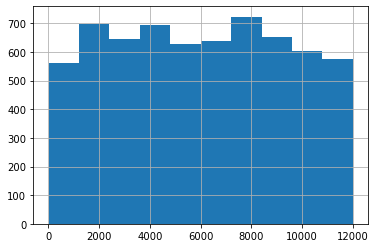

In [12]:
user.invited_by_user_id.hist()

In [64]:
#According to the grap,it will be seen that there is not skew with the data
#So we will fill NULL values with mean value
user.invited_by_user_id.fillna(user.invited_by_user_id.mean(), inplace=True)

In [65]:
#Convert the creation_time to numeric value
user['creation_time'] = pd.to_numeric(pd.to_datetime(user.creation_time))

#Drop unnecessary columns
user.drop(['name', 'email'], axis=1, inplace=True)
user.head()

,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,status
object_id,,,,,,,,
1,1398138810000000000,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
2,1384487104000000000,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
3,1363734892000000000,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
4,1369123768000000000,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
5,1358417660000000000,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


In [66]:
#One hot encode for creation_source column
crt_src = pd.get_dummies(user['creation_source'])
df = pd.concat([user, crt_src], axis=1)
df.drop('creation_source', axis=1, inplace=True)
df.head()

,creation_time,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,status,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
object_id,,,,,,,,,,,,
1,1398138810000000000,1.398139e+09,1,0,11,10803.0,0,1,0,0,0,0
2,1384487104000000000,1.396238e+09,0,0,1,316.0,1,0,1,0,0,0
3,1363734892000000000,1.363735e+09,0,0,94,1525.0,0,0,1,0,0,0
4,1369123768000000000,1.369210e+09,0,0,1,5151.0,0,1,0,0,0,0
5,1358417660000000000,1.358850e+09,0,0,193,5240.0,0,1,0,0,0,0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   creation_time               12000 non-null  int64  
 1   last_session_creation_time  8823 non-null   float64
 2   opted_in_to_mailing_list    12000 non-null  int64  
 3   enabled_for_marketing_drip  12000 non-null  int64  
 4   org_id                      12000 non-null  int64  
 5   invited_by_user_id          12000 non-null  float64
 6   status                      12000 non-null  int64  
 7   GUEST_INVITE                12000 non-null  uint8  
 8   ORG_INVITE                  12000 non-null  uint8  
 9   PERSONAL_PROJECTS           12000 non-null  uint8  
 10  SIGNUP                      12000 non-null  uint8  
 11  SIGNUP_GOOGLE_AUTH          12000 non-null  uint8  
dtypes: float64(2), int64(5), uint8(5)
memory usage: 808.6 KB


In [67]:
#Split the dataset to train-test set
X = df.drop('status', axis=1)
y = df['status']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.3)

In [68]:
#Create a dictionary for hyperparameters, contains parameters and values.
params = {'n_estimators':[250, 500],
          'max_depth':[5, 10, 15, 20],
         'learning_rate':[0.05],
         'n_splits':[2]}

#Instantiate the classifier
xgb_classifier = XGBClassifier()

#Gridsearch parameterization tunning
grid_search = GridSearchCV(param_grid= params, estimator = xgb_classifier, 
                           cv=5, scoring='accuracy')

#Execute the search 
model_result = grid_search.fit(X_train,y_train)

C:\Users\kurt_\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:20:51] WARNING: ..\src\learner.cc:541: 
Parameters: { n_splits } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:20:51] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:51] WARNING: ..\src\learner.cc:541: 
Parameters: { n_splits } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:20:51] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluatio

In [69]:
# The best n_estimator
print(model_result.best_params_)
print(model_result.best_score_)

{'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 250, 'n_splits': 2}
0.9757142857142856


In [70]:
#Check the model result
#Predict labels from train data
y_pred = model_result.predict(X_train)

#Score model
score = accuracy_score(y_train, y_pred)

#Print accuracy
print(f"The accuracy of the model is {round(score,8)} based on training set.")

The accuracy of the model is 0.9897619 based on training set.


In [71]:
#Predict the labels
y_pred = model_result.predict(X_test)
# score model
score = accuracy_score(y_test, y_pred)
#Print accuracy
print(f"The accuracy of the model based on test set. is {round(score,8)}")

The accuracy of the model based on test set. is 0.97805556


In [72]:
from sklearn import metrics
print(metrics.confusion_matrix(y_test, y_pred))

[[3134   35]
 [  44  387]]


Feature: 0, Score: 0.28
Feature: 1, Score: 0.47
Feature: 2, Score: 0.02
Feature: 3, Score: 0.02
Feature: 4, Score: 0.03
Feature: 5, Score: 0.03
Feature: 6, Score: 0.04
Feature: 7, Score: 0.03
Feature: 8, Score: 0.04
Feature: 9, Score: 0.02
Feature: 10, Score: 0.02


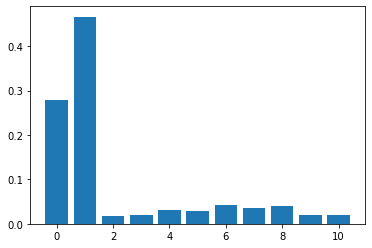

In [93]:
#Calculate the feature importance
importance = model_result.best_estimator_.feature_importances_

#Summarize feature importance
for i, v in enumerate(importance):
    print('Feature: %0d, Score: %.2f' % (i,v))
    
#Plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [97]:
display(df['last_session_creation_time'].corr(df['status']))
display(df['creation_time'].corr(df['status']))

0.40320994934811727

-0.09831205141840425

In [94]:
#Check for the important columns which have higher relation with the target
pd.DataFrame(model_result.best_estimator_.feature_importances_, 
             index = X_train.columns, columns = ['importance']).sort_values('importance', ascending=False)

,importance
last_session_creation_time,0.466100
creation_time,0.279212
GUEST_INVITE,0.042459
PERSONAL_PROJECTS,0.039120
ORG_INVITE,0.034610
org_id,0.031007
invited_by_user_id,0.029201
SIGNUP,0.020774
enabled_for_marketing_drip,0.020268
SIGNUP_GOOGLE_AUTH,0.019637


# Conclusion

According to the model prediction, the accuracy is 97.5%. And, in terms of feature importance relation, the most important features are last_session_creation_time and creation_time. 